In [1]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, Input, MaxPooling2D, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

BASE_DIR = '/kaggle/input/utkface-new/UTKFace'
IMG_SIZE = (128, 128)
BATCH_SIZE = 128
EPOCHS = 100

2025-08-05 14:07:28.618860: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754402848.971693      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754402849.070192      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
def load_data():
    images, genders = [], []
    for file in tqdm(os.listdir(BASE_DIR)):
        temp = file.split('_')
        if len(temp) >= 2 and temp[1].isdigit():
            genders.append(int(temp[1]))
            img_path = os.path.join(BASE_DIR, file)
            img = tf.keras.preprocessing.image.load_img(img_path, target_size=IMG_SIZE, color_mode='grayscale')
            img = tf.keras.preprocessing.image.img_to_array(img) / 255.0
            images.append(img)
    
    images = np.array(images)
    genders = np.array(genders)
    return images, genders

In [3]:
def get_data_augmentation():
    return tf.keras.Sequential([
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.2),
        tf.keras.layers.RandomZoom(0.2),
    ])

In [4]:
def build_model():
    inputs = Input(shape=(128, 128, 1))
    x = get_data_augmentation()(inputs)
    
    x = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.0001))(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.0001))(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.0001))(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001))(x)
    x = Dropout(0.5)(x)
    
    gender_output = Dense(1, activation='sigmoid', name='gender')(x)
    
    model = Model(inputs=inputs, outputs=gender_output)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    model.summary()
    return model

In [5]:
def compute_gender_class_weights(genders):
    classes = np.unique(genders)
    class_weights = compute_class_weight('balanced', classes=classes, y=genders)
    return {0: class_weights[0], 1: class_weights[1]}

In [6]:
def compute_sample_weights(genders, class_weights):
    sample_weights = np.zeros(len(genders))
    for i, gender in enumerate(genders):
        sample_weights[i] = class_weights[gender]
    return sample_weights

100%|██████████| 23708/23708 [03:08<00:00, 126.04it/s]
I0000 00:00:1754403058.273598      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1754403058.274319      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,194,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gender (Dense)                  │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,288,129 (16.36 MB)

 Trainable params: 4,287,681 (16.36 MB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/100


I0000 00:00:1754403069.266504      96 cuda_dnn.cc:529] Loaded cuDNN version 90300


112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.5979 - loss: 1.9312
Epoch 1: val_accuracy improved from -inf to 0.47807, saving model to /kaggle/working/gendertask6.weights.h5
112/112 ━━━━━━━━━━━━━━━━━━━━ 29s 160ms/step - accuracy: 0.5981 - loss: 1.9237 - val_accuracy: 0.4781 - val_loss: 7.6517
Epoch 2/100
111/112 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.6689 - loss: 0.6563
Epoch 2: val_accuracy did not improve from 0.47807
112/112 ━━━━━━━━━━━━━━━━━━━━ 16s 146ms/step - accuracy: 0.6690 - loss: 0.6563 - val_accuracy: 0.4781 - val_loss: 9.5414
Epoch 3/100
111/112 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.6960 - loss: 0.6278
Epoch 3: val_accuracy improved from 0.47807 to 0.49325, saving model to /kaggle/working/gendertask6.weights.h5
112/112 ━━━━━━━━━━━━━━━━━━━━ 17s 150ms/step - accuracy: 0.6960 - loss: 0.6278 - val_accuracy: 0.4933 - val_loss: 3.2380
Epoch 4/100
111/112 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.7011 - loss: 0.6093
Epoch 4: val_accuracy impr

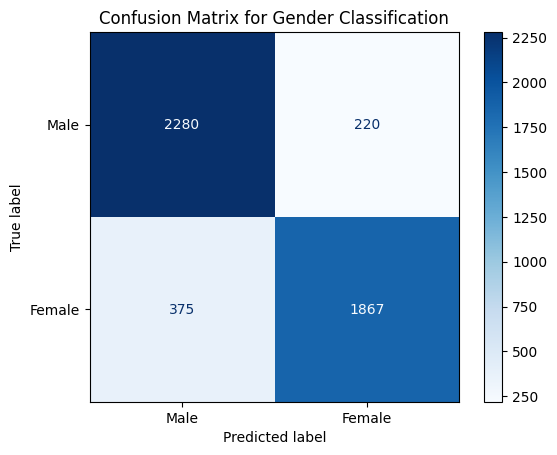

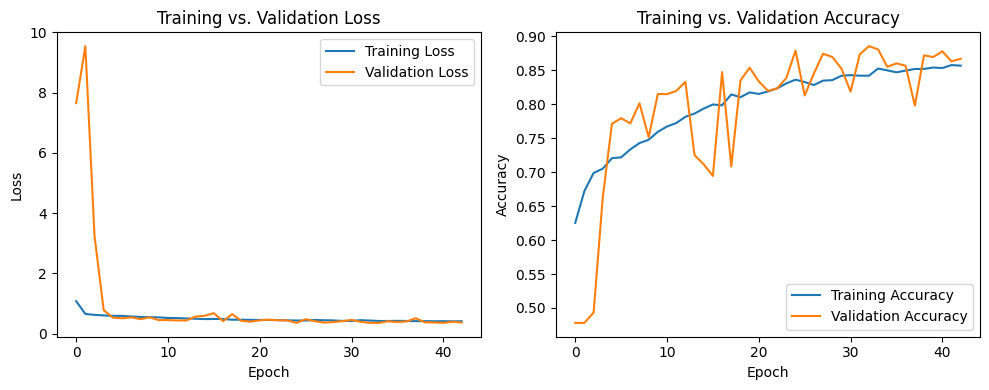

In [7]:
images, genders = load_data()
X_temp, X_test, y_temp_gender, y_test_gender = train_test_split(
    images, genders, test_size=0.2, random_state=42, shuffle=True
)
X_train, X_val, y_train_gender, y_val_gender = train_test_split(
    X_temp, y_temp_gender, test_size=0.25, random_state=42, shuffle=True 
)

class_weights = compute_gender_class_weights(y_train_gender)
sample_weights = compute_sample_weights(y_train_gender, class_weights)
model = build_model()
checkpoint = ModelCheckpoint(
        '/kaggle/working/gendertask6.weights.h5',
        monitor='val_accuracy',
        save_best_only=True,
        save_weights_only=True,
        mode='max',
        verbose=1
)
early_stopping = EarlyStopping(
        monitor='val_accuracy',
        patience=10,
        restore_best_weights=True,
        mode='max'
)
history = model.fit(
        X_train,
        y_train_gender,
        validation_data=(X_val, y_val_gender),
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        callbacks=[checkpoint,early_stopping],
        sample_weight=sample_weights,
        verbose=1
)

final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]

print(f"\nFinal Training Accuracy: {final_train_acc:.4f}")
print(f"Final Validation Accuracy: {final_val_acc:.4f}")
print(f"Final Training Loss: {final_train_loss:.4f}")
print(f"Final Validation Loss: {final_val_loss:.4f}")

model.load_weights('/kaggle/working/gendertask6.weights.h5')
test_loss, test_accuracy = model.evaluate(X_test, y_test_gender, verbose=1)
#Computing precision, recall and F1 score
y_pred = model.predict(X_test, verbose=0)
y_pred_binary = (y_pred > 0.5).astype(int).flatten()
precision = precision_score(y_test_gender, y_pred_binary)
recall = recall_score(y_test_gender, y_pred_binary)
f1 = f1_score(y_test_gender, y_pred_binary)
cm = confusion_matrix(y_test_gender, y_pred_binary)
print(f"Test Gender Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test F1 Score: {f1:.4f}")

#Plotting confusion matrix
class_labels = ["Male", "Female"]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Gender Classification")
plt.show()
model.save('/kaggle/working/gendertask6.h5')

plt.figure(figsize=(10, 4))   
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs. Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs. Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()